In [48]:
#Import PyTorch and matplotlib
import torch
import torchvision
from torch import nn
from torchvision import transforms
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import time
from pthflops import count_ops

vRead = iio.imread("c_elegans.mp4")
video = np.array(vRead)

#Check PyTorch version
torch.__version__


'1.13.1'

### SET GPU if possible
run in shell: 
CUDA_VISIBLE_DEVICES= {gpu#/#s}

In [49]:
print("Is cuda available?", torch.cuda.is_available())

print("Is cuDNN version:", torch.backends.cudnn.version())

print("cuDNN enabled: ", torch.backends.cudnn.enabled)

print("Device count: ", torch.cuda.device_count())

print("Current device: ", torch.cuda.current_device())

print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
#Setup device agnostic code (i.e use GPU if possible)
device = "cuda" if torch.cuda.is_available() else "cpu"
gpuNum = 1

Is cuda available? True
Is cuDNN version: 8302
cuDNN enabled:  True
Device count:  4
Current device:  0
Device name:  NVIDIA GeForce RTX 3090


In [50]:
#Video Metadata
import imageio.v3 as iio
props = iio.improps("c_elegans.mp4")
print("Shape (frames, w, h, RGB): \n" + str(props.shape))
print(props.dtype)

Shape (frames, w, h, RGB): 
(2484, 322, 344, 3)
uint8


### Encoding image data as tensors

In [51]:
#Input grid  (frame, width_px, height_ px)
grid = torch.empty(props.shape[0], props.shape[1], props.shape[2]).to(device)

# Create video tensor
numFrames = 1
video = video[0:numFrames] # frame selection
video = torch.tensor(video, dtype=torch.int32).to(device)
print(video.dtype)

#Generate input and output vectors for training and testing
temp = video.clone()
X = temp.squeeze(dim=1)
X.shape


torch.int32


torch.Size([1, 322, 344, 3])

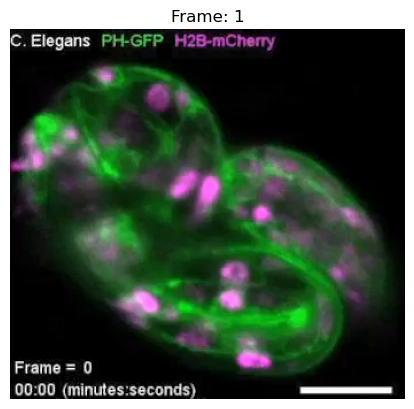

In [52]:
testFrame = 0
plt.imshow(video[testFrame].cpu())
plt.axis(False)
plt.title("Frame: " + str(testFrame + 1));


### Differentiable Model (MLP-based Model)

In [76]:
import torch
from torch import nn
#from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms

#Use seed for reproducibility
torch.manual_seed(42)
#Multilayer Percepetron Model 
class MLP(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
        nn.Linear(input_shape, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, output_shape),
        )
    #forward reconstruction
    def forward(self, X):
        return self.layer_stack(X.to(device))
    


In [77]:
#Create an Instance and set loss function & optimizer
model_0 = MLP(input_shape=3, 
              hidden_units=128, 
              output_shape=3).to(device)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.00001)
#list(model_0.parameters())


### Testing Loop (creates some example frame to visualize loss)

In [78]:
# Tests to reconstruct image for some frame
def test_loop():
    model_0.eval()
    with torch.inference_mode():
        frame = 0
        results = torch.zeros(len(grid[0]), len(grid[0][0]), 3)
        for row in range(0, len(grid[0])):
            for col in range(0, len(grid[0][0])):
                T = torch.tensor([[frame, row, col]], dtype=torch.float32).to(device)
                results[row][col] = torch.round(model_0(T.squeeze(dim=1))).to(device)
        plt.imshow(results.cpu())
                  

### Training Loop


In [79]:
import tqdm

def trainLoop():
  #Track values
  epoch_count = []
  loss_values = []
  test_loss_values = []
  #Loop through data
  for epoch in range(0, 50):
      epoch_count.append(epoch)
      # Set current loss value
      current_loss = 0.0
      # Set Model to training mode
      model_0.train()

      for frame in range(0, 1):
         for row in range(0, len(grid[0])):
            print("frame: " + str(frame) + " " + "row : " + str(row))
            for col in range(0, len(grid[0][0])):
              ###Coordinate Training
              #Forward Pass
              X = torch.tensor([[frame * 1.0, row * 1.0, col * 1.0]], dtype=torch.float32).to(device)
              pred = torch.round(model_0(X.squeeze(dim=1).to(device))).to(device)
              # Compute loss (training)
              loss = loss_fn(pred, torch.tensor(video[frame][row][col].to(device), dtype=torch.float32).to(device))
              #print(pred, loss)
              # Zero the gradients
              optimizer.zero_grad()
              # Perform backpropagation on loss with respect to params
              loss.backward()
              optimizer.step()
         #test_loop()
      #Stat things
      if(epoch % 10 == 0):
          epoch_count.append(epoch)
          loss_values.append(loss)
          #test_loss_values.append(test_loss)
          print(f"Epoch {epoch} | Loss: {loss} | Test loss: ")
          # Print out the model state_dict()
          print(model_0.state_dict())
        

  print('Training finished')


In [ ]:
trainLoop()  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


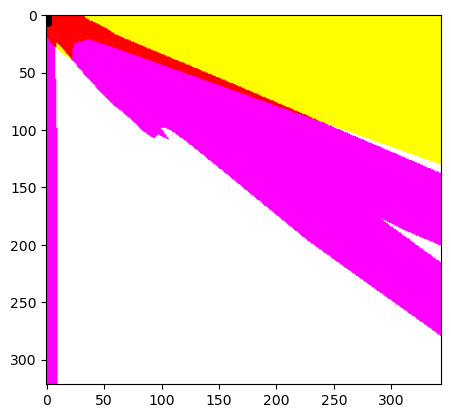

In [81]:
test_loop()

### Check Size of Model

In [75]:
# Check model size by summing parameters and state_dict
params_size = 0
for param in model_0.parameters():
    params_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model_0.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (params_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 0.066MB
